In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/TFM_DSBD'

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("figure", figsize=(15, 5))

import keras
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout, Flatten

import os 
from src.config import LM_PER_VIDEO, BASE_OUTPUT, TOTAL_LANDMARKS
from sklearn.utils import shuffle
from utils import load_dict

In [3]:
subset_size = 10
subset = f"subset_{subset_size}_lsa_64"
model_type = "mediapipe"
model_name = "mp"

In [4]:
X_tens = load_dict(f"./data/{subset}/pickl_files/npy_db_x.pkl")
Y_enc = load_dict(f"./data/{subset}/pickl_files/npy_db_y.pkl")
le_mapping = load_dict(f"./data/{subset}/pickl_files/labels_map.pkl")

In [5]:
# Assign the dataset splits
X_train, X_val, X_test = X_tens['train'], X_tens['val'], X_tens['test']
y_train, y_val, y_test = Y_enc['train'], Y_enc['val'], Y_enc['test']
n_classes = len(le_mapping)

# shuffling the data
X_train, y_train = shuffle(X_train, y_train)
X_val, y_val = shuffle(X_val, y_val)
X_test, y_test = shuffle(X_test, y_test)

In [6]:
# Mediapipe normalizes data for us
X_train[0].all() < 1 

True

In [7]:
X_train.shape, X_val.shape, X_test.shape

((394, 20, 1662), (60, 20, 1662), (46, 20, 1662))

In [8]:
y_train.shape, y_val.shape, y_test.shape

((394,), (60,), (46,))

In [9]:
model = Sequential([
    LSTM(units=128, activation='tanh', return_sequences=True, input_shape=(LM_PER_VIDEO, TOTAL_LANDMARKS)),
    Dropout(0.2),
    LSTM(units=256, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(units=128, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(units=64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=n_classes, activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           916992    
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 256)           394240    
                                                                 
 dropout_1 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           197120    
                                                                 
 dropout_2 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                4

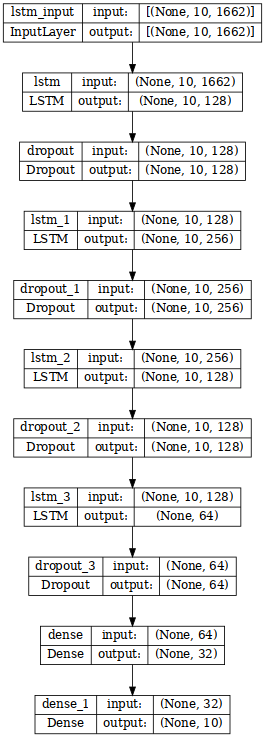

In [10]:
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [11]:
epochs = 500
bst_model_path = "src/"+model_type+"/bestmodels/best_"+model_name+"_{epoch:02d}_{val_accuracy:.2f}"+subset_size+"_model.h5"

callbacks = [
    #EarlyStopping(monitor="loss", patience=15),
    #EarlyStopping(monitor="accuracy", patience=15),
    MyThresholdCallback(threshold=0.94),
    ModelCheckpoint(filepath = bst_model_path, save_best_only=True, save_weights_only=True, monitor="accuracy")
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=callbacks,
    batch_size=32
)

Epoch 1/500
13/13 [==============================] - 6s 82ms/step - loss: 2.3069 - accuracy: 0.0914 - val_loss: 2.2995 - val_accuracy: 0.2000
Epoch 2/500
13/13 [==============================] - 0s 17ms/step - loss: 2.2833 - accuracy: 0.1421 - val_loss: 2.2932 - val_accuracy: 0.1000
Epoch 3/500
13/13 [==============================] - 0s 18ms/step - loss: 2.2318 - accuracy: 0.1929 - val_loss: 2.2134 - val_accuracy: 0.1833
Epoch 4/500
13/13 [==============================] - 0s 16ms/step - loss: 2.1549 - accuracy: 0.2081 - val_loss: 2.1310 - val_accuracy: 0.2167
Epoch 5/500
13/13 [==============================] - 0s 18ms/step - loss: 2.0897 - accuracy: 0.2183 - val_loss: 2.0679 - val_accuracy: 0.2333
Epoch 6/500
13/13 [==============================] - 0s 16ms/step - loss: 2.0260 - accuracy: 0.2589 - val_loss: 1.9761 - val_accuracy: 0.2500
Epoch 7/500
13/13 [==============================] - 0s 16ms/step - loss: 1.9205 - accuracy: 0.3071 - val_loss: 1.9109 - val_accuracy: 0.2667
Epoch 

In [ ]:
best_model_epoch = np.argmax(history.history['val_accuracy'])
best_acc, best_loss, best_val_acc, best_val_loss = history.history['accuracy'][best_model_epoch], history.history['loss'][best_model_epoch], history.history['val_accuracy'][best_model_epoch], history.history['val_loss'][best_model_epoch]

In [ ]:
best_model = tf.keras.models.load_model(f"src/convlstm/{model_type}/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_{subset_size}_model.h5")

In [12]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_results = best_model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", test_results)

Evaluate on test data
2/2 [==============================] - 0s 7ms/step - loss: 0.2786 - accuracy: 0.9348
test loss, test acc: [0.27860620617866516, 0.9347826242446899]


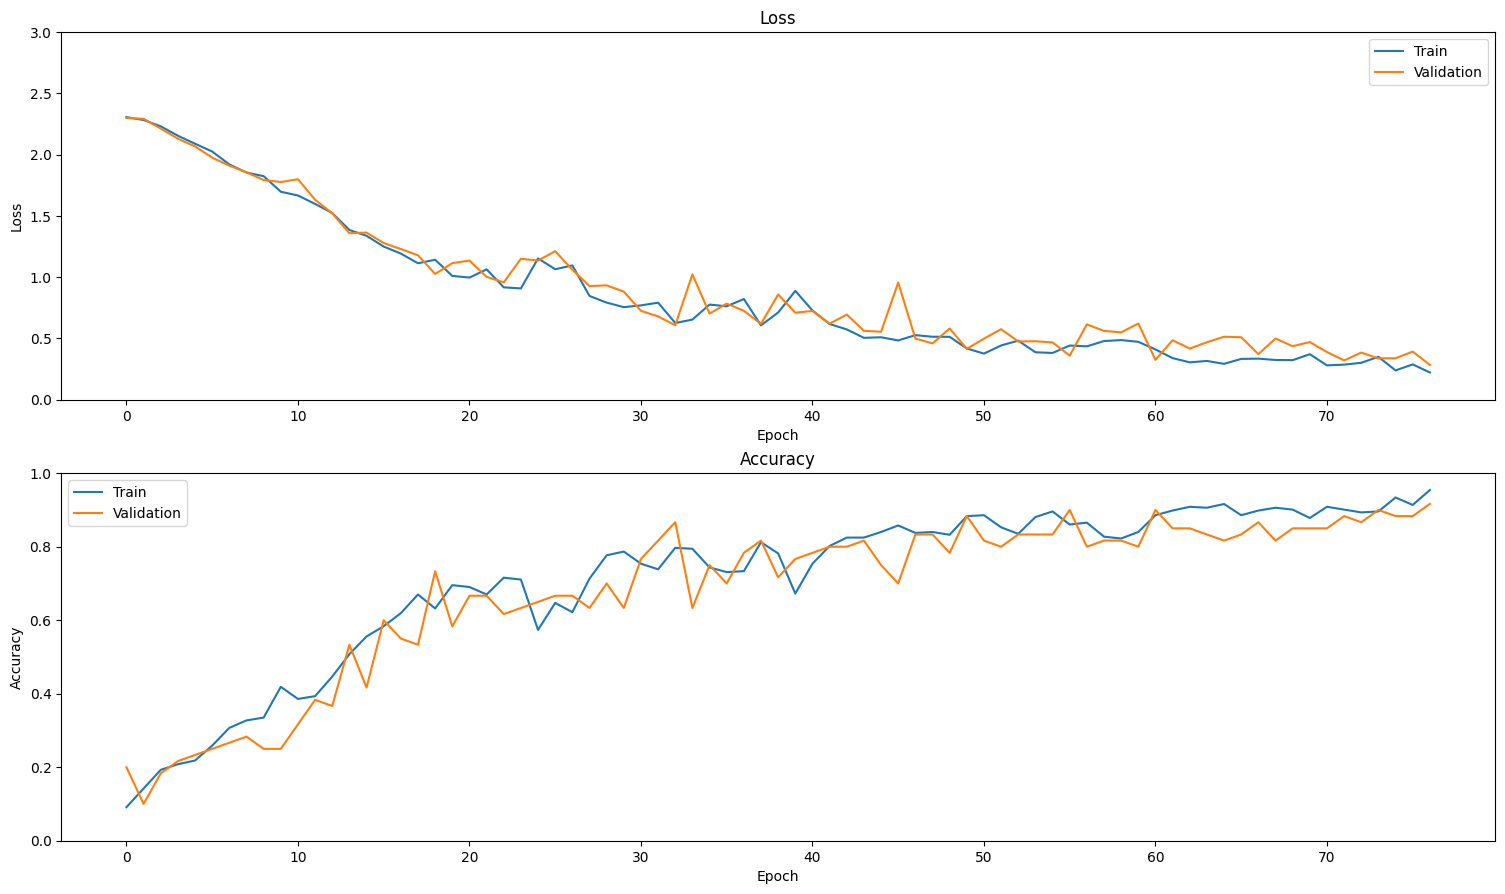

In [13]:
from src.plot_utils import plot_history
plot_history(history=history)

In [ ]:
# Update leaderboard in case a new best model is found
from src.leaderboard import Leaderboard

lb = Leaderboard()
lb.update_leaderboard(history=history,
                      test_results=test_results,
                      model_name=model_name,
                      model_type=model_type,
                      subset_size=subset_size)